# 4 Modelado del conjunto de datos
A lo largo de este notebook se cubre parte de la cuarta fase de la metodología CRIPS-DM, en este caso el desarrollo del modelo final. En este caso, el modelo se trata de un ensemble que combina el mejor predictor, RetinaNet, el mejor segmentador SAM, y la adición de una red variante de la UNET que corrige errores del modelo final.

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo y requisitos del proyecto, traduciendo las necesidades a una definición analítica del problema y una estrategia para abordarlo.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en carga y análisis exploratorio del conjunto de datos.

3. **Preparación de los Datos (Data Preparation)**
   - Consistente en la limpieza, preparación y extracción de características de los datos, de vital importancia para el modelado dado que determinará la calidad de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span>
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina la obtención de detecciones de objetos mediante `RetinaNet`, la obtención de las máscaras mediante `Segment Anything Model` y la corrección de errores de una variante de la `UNET`.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo, determinando si cumple con los requisitos definidos en la primera de las fases y si es factible su implementación.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso, en este caso mediante una aplicación web.

### Implementación

El entrenamiento de este modelo ensemble tipo stacking puede dividirse en dos bloques diferenciados, en primer lugar la pipeline de inferencia preentrenada, cuyos pesos quedan bloqueados y se limitan a generar las predicciones en formato *raw* y en segundo lado el modelo de corrección `UNET`, cuyos pesos serán entrenados desde cero.

Dado que uno de los grandes blottlenecks del entrenamiento del modelo *Baseline* se ha tratado del tiempo de entrenamiento debido a la falta de recursos computacionales, para el entrenamiento del modelo se automatizará la generación del `tf.Dataset` a emplear por el segundo modelo, sin aplicar data augmentation, dado que el tiempo de inferncia medio del modelo es de 30 segundos para su primera fase.



### 1. Pipeline de inferencia del primer bloque

A continuación, se desarrolla la pipeline del primer bloque del modelo y se automatiza su carga en la estuctura de datos elegida


In [1]:
#import importlib
#import utils


from tqdm import tqdm
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T
from IPython.display import clear_output

from PIL import Image
import torch
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
from utils import  load_yaml_file

import matplotlib.pyplot as plt
import time


from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import tensorflow as tf

from keras.saving import register_keras_serializable

from utils import plot_image_and_mask, mask_generator,plot_bounding_boxes, plot_differences_batch, plot_one_hot_encoded_masks_norm, one_hot_encoder_masks, plot_differences, get_data_id_image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#from google.colab import drive
import keras
import random
from sklearn.metrics import average_precision_score
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
import matplotlib.pyplot as plt



Al igual que en el resto de notebooks, se cargan las variables y estructuras de datos necesarias:

In [2]:
yaml = load_yaml_file()
objetives = yaml["objetive_classes"]
N = yaml["size_sample"]

In [3]:

N_CLASSES = len(objetives) + 1 # Se incluye el background que estara en el canal 0

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=37.66s)
creating index...
index created!


In [4]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

Se definen los thersholds de segmentación y detección para el primer bloque del ensemble:

In [5]:
CONS_TRHESHOLD = 0.3
CONS_THRESHOLD_SEGMENTATION = 0.3

In [6]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)



In [8]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [9]:

retina_model = retinanet_resnet50_fpn(pretrained=True)
retina_model.eval()

c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [10]:
def get_one_hot_mask(current_scores, mask,categories_names_by_index ):

    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase, :, :] = np.where(mask == clase,current_scores , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

def process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive):

    # RETINANET INFERENCE

    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        inference = retina_model(img_tensor)
        inference = inference[0]


    # SAM INFERENCE

    sam_model.set_image(image)
    final_mask = np.zeros(image.shape[:2], dtype=np.int8)
    current_scores = np.zeros(image.shape[:2], dtype=np.float32)

    masks_image = []
    scores_image = []
    labels_image = []
    #category_info_objetive = {v: k for k, v in categories_index_by_name.items()}
    # print(inference)
    # print(f"{inference['boxes']}=")

    flag_found = 0

    for box, score, label in zip(inference['boxes'], inference['scores'], inference['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            label = mapper_indexModel_index_result[label.item()]
            masks, scores, _ = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None,:],
                multimask_output=False
            )
            if np.any(masks):
                flag_found = 1
                masks_image.append(masks)
                scores_image.append(scores)
                labels_image.append(label)

                mask_values = np.where(masks, scores, 0)
                final_mask = np.where(mask_values > current_scores , label, final_mask)
                current_scores = np.maximum(mask_values, current_scores)

    # Output preprocessing
    if(flag_found):
        final_mask = final_mask[0]
    current_scores = current_scores[0]
    final_mask = get_one_hot_mask(current_scores, final_mask,categories_names_by_index )



    return final_mask, current_scores


In [11]:
image, mask = get_data_id_image(img_ids[0], coco,DIR_TRAIN_IMGS , category_info_objetive)

final_mask, current_scores = process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive)

In [16]:
tfrecord_path_train = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_train_first_block_final_model.tfrecord"
tfrecord_path_test = r"C:\Users\ruben\Desktop\code_tfm\src\dataset_test_first_block_final_model.tfrecord"
N_CLASSES = 11
batch_size = 16

In [17]:
def redimensionar_recorte(img, mask, target_shape):

    input_alt,input_anc,_= img.shape
    target_alt,target_anc,_= target_shape

    recorte= img[:min(input_alt, target_alt),:min(input_anc, target_anc), :]
    mascara_recorte =mask[:min(input_alt, target_alt),:min(input_anc, target_anc)]

    padding_top = max(target_alt-recorte.shape[0],0)
    padding_dcha = max(target_anc-recorte.shape[1],0)

    padded = np.pad(recorte,((padding_top, 0),(0,padding_dcha),(0,0)),mode='constant',constant_values=0)
    padded_mascara = np.pad(mascara_recorte,((padding_top,0),(0,padding_dcha)),mode='constant',constant_values=0)

    return padded, padded_mascara

In [24]:
CONST_THRESHOLD_SIZE_CROPPING = 100

def insertar_mascara_random(img, mask_orig, target_class, target_channel):


    while True:

        img_ids =  coco.getImgIds(catIds=[target_class])
        target_id = random.choice(img_ids)
        target_info  = coco.loadImgs(target_id)[0]
        target_path  = os.path.join(DIR_TRAIN_IMGS,target_info['file_name'])
        target = cv2.imread(target_path)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=target_id,  catIds=[target_class],  iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        ann = random.choice(anns)
        mascara_target = coco.annToMask(ann)


        shape = img.shape
        target, mascara_target = redimensionar_recorte(target,mascara_target,shape)

        if np.sum(mascara_target) > CONST_THRESHOLD_SIZE_CROPPING:
            break

    bool_mascara_3d = mascara_target[:,:,np.newaxis]
    result_imagen = np.where(bool_mascara_3d,target,img)
    mask_orig[mascara_target.astype(bool)] = target_channel


    return result_imagen, mask_orig

In [25]:
def serialize_example(img_id, coco,path_images, id_objetives ):

    img, mask = mask_generator(coco, img_id, ids_masks= id_objetives  ,path_images = path_images)
    #print("masl", np.unique(mask))
    mask=np.vectorize(lambda x:dict_class_index.get(x,x))(mask)
    img = np.array(img)
    for _ in range(4):
        class_cropping = random.choice(id_objetives)
        target_channel = mapper_indexModel_index_result[class_cropping]
        img, mask = insertar_mascara_random(img, mask, class_cropping,target_channel)


    ###   PIPELINE INFERENCE   #####
    _ , current_scores  = process_inference_retina_sam(image, retina_model, sam_model, mapper_indexModel_index_result, category_info_objetive)

    # print("shae", mask.shape)
    # print("masl", np.unique(mask))

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    img_codificada = tf.io.encode_jpeg(img).numpy()
    mask = mask.astype(np.uint8)
    mask_raw = mask.tobytes()
    mask_shape = list(mask.shape)

    pipeline_output =  current_scores.astype(np.uint8)
    pipeline_output  = pipeline_output.tobytes()


    feature = {
        "image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_codificada])),
        "pipeline_output":tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask":tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask_shape":tf.train.Feature(int64_list=tf.train.Int64List(value=mask_shape))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()



In [26]:
batch_size = 16
total_id_images = img_ids[:batch_size*(len(img_ids)//batch_size)]

In [27]:
proportion_train_test = 0.95
n_batches_train  = round((len(total_id_images)//batch_size)*proportion_train_test)

#train_image_ids = random.sample(total_id_images, n_batches_train*batch_size)
#test_image_ids = [item for item in total_id_images if item not in train_image_ids]

train_image_ids = random.sample(total_id_images, 500*batch_size)
test_image_ids = random.sample(total_id_images, 30*batch_size)

In [ ]:
with tf.io.TFRecordWriter(tfrecord_path_train) as writer:
    
    for img_id in tqdm(train_image_ids, desc="Generando Conjunto de datos Train"):
        example = serialize_example(img_id,coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

with tf.io.TFRecordWriter(tfrecord_path_test) as writer:
    for img_id in tqdm(test_image_ids, desc="Generando Conjunto de datos Test"):
        example = serialize_example(img_id, coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

Generando Conjunto de datos Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Generando Conjunto de datos Test: 100%|██████████| 480/480 [3:22:16<00:00, 25.29s/it]  


In [ ]:
# dataset = tf.data.TFRecordDataset([
#     "train_000.tfrecord",
#     "train_001.tfrecord",
#     "train_002.tfrecord"
# ])

In [6]:
def parse_tfrecord_aux(example_proto):

    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "pipeline_output": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "mask_shape": tf.io.FixedLenFeature([2], tf.int64),
    }

    example = tf.io.parse_single_example(example_proto, feature_description)

    img =tf.io.decode_jpeg(example["image"])
    img = tf.image.convert_image_dtype(img,tf.float32)

    shape = example["mask_shape"]

    mask =tf.io.decode_raw(example["mask"],tf.uint8)
    mask =tf.reshape(mask, shape)
    mask =tf.one_hot(mask, depth=N_CLASSES)

    mask_pipeline =tf.io.decode_raw(example["pipeline_output"],tf.uint8)
    mask_pipeline =tf.reshape(mask_pipeline, shape)
    mask_pipeline = tf.expand_dims(mask_pipeline, axis=-1)

    #print(f"{mask_pipeline.shape=}")
    #print(f"{mask.shape=}")

    final_input = tf.concat([img, tf.cast(mask_pipeline, tf.float32)], axis=-1)

    return final_input,mask

In [ ]:
def carga_dataset(tfrecord_path, batch_size=32, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord_aux, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        #dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} C:\Users\ruben\Desktop\code_tfm\src\dataset_train_final.tfrecord; No such file or directory [Op:IteratorGetNext] name: 

In [ ]:
# import tensorflow as tf

# # Paso 1: copiar contenido del dataset original al nuevo archivo
# with tf.io.TFRecordWriter("nuevo_dataset.tfrecord") as writer:
#     for record in tf.data.TFRecordDataset("original.tfrecord"):
#         writer.write(record.numpy())

#     # Paso 2: añadir nuevos ejemplos
#     for img_id in nuevas_imagenes:
#         example = serialize_example(img_id, coco, DIR_TRAIN_IMGS, id_objetives)
#         writer.write(example)

### 1.2 Data augmentation

Se modifica la fase de data augmentation para no afectar al canal que contiene la salida del pipeline de la primera fase de la inferencia. La nueva función de data augmentation es tal que:



In [7]:
def augment_data(image, mask):
    ### Flipeo aleatorio de la imagen
    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    ### Rotacion uniforme de la imagen
    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(minval=0, maxval=4, dtype=tf.int32, shape=[])
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)

    ### Separar canales
    rgb = image[:, :, :3]
    fourth_channel = image[:, :, 3]

    ### Ajuste de brillo SOLO en RGB
    if tf.random.uniform(()) > 0.85:
        rgb = tf.image.adjust_brightness(rgb, delta=tf.random.uniform([], -0.1, 0.1))

    ### Ajuste de contraste SOLO en RGB
    if tf.random.uniform(()) > 0.85:
        rgb = tf.image.adjust_contrast(rgb, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    ### Aplicación de ruido gaussiano SOLO en RGB
    noise = tf.random.normal(shape=tf.shape(rgb), mean=0.0, stddev=0.05, dtype=tf.float32)
    rgb = tf.clip_by_value(rgb + noise, 0.0, 1.0)

    ### Con probabilidad 0.2 por pixel, poner a 0 el canal 4
    mask_prob = tf.random.uniform(tf.shape(fourth_channel), 0, 1)
    zero_mask = tf.cast(mask_prob > 0.2, tf.float32)
    fourth_channel = fourth_channel * zero_mask

    ### Reconstruir imagen
    image = tf.concat([rgb, tf.expand_dims(fourth_channel, axis=-1)], axis=-1)

    return image, mask


### 2. Implementación del modelo corrector

Para el entrenamiento de esta segunda parte del modelo se procede a la carga de datos en drive para poder hacer uso de google colab para el entrenamiento usando GPU.

Es por ello que se procede de nuevo a la carga del conjunto de train y de test almacenados como `tf.Dataset`, empleando los paths de google drive correspondientes.

In [8]:
from google.colab import drive
import matplotlib.patches as mpatches

drive.mount('/content/drive')

tfrecord_path_train = r"/content/drive/MyDrive/TFM/dataset_train_final_2.tfrecord"
tfrecord_path_test = r"/content/drive/MyDrive/TFM/dataset_test_final_2.tfrecord"

batch_size = 16

N_CLASSES = 11

Mounted at /content/drive


In [9]:
def carga_dataset(tfrecord_path, batch_size=32, size_mezcla=100, training=True):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord_aux, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset=dataset.shuffle(size_mezcla)
        dataset=dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = carga_dataset(tfrecord_path_train, batch_size=4)

for img_batch, mask_batch in train_ds.take(1):
    print("Dim del primer batch de Train", img_batch.shape)
    print("Dim del primer mask_batch de Train", mask_batch.shape)

Dim del primer batch de Train (4, 256, 256, 4)
Dim del primer mask_batch de Train (4, 256, 256, 11)


In [10]:
category_info_objetive = {1: 'person',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 10: 'traffic light',
 27: 'backpack',
 31: 'handbag',
 77: 'cell phone',
 62: 'chair',
 67: 'dining table',
 0: 'background'}

In [11]:
def plot_image_and_mask(image, mask):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(mask)])

    # Uso de templates de colores predefinidas en matplot para que exista mas contraste entre clases de ids adyacentes, usando tab10
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    # Se incializa la mascara como todo fondo, y se itera añadiendo
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Máscara")
    ax[1].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-11-4257581388.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


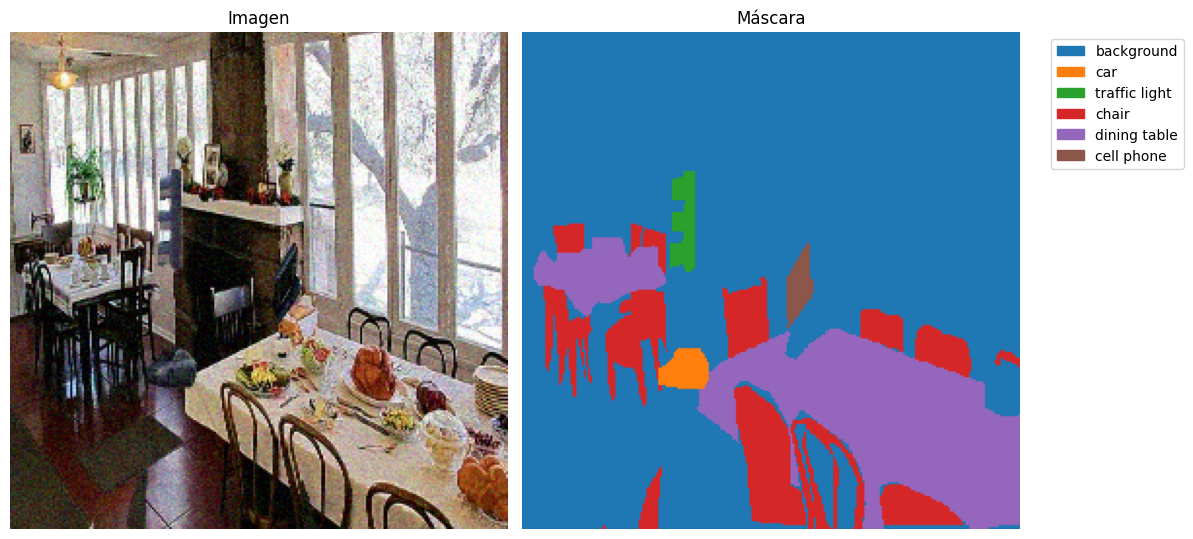

In [ ]:
plot_image_and_mask(img_batch[3,:,:,:3], mask_batch[3,...])

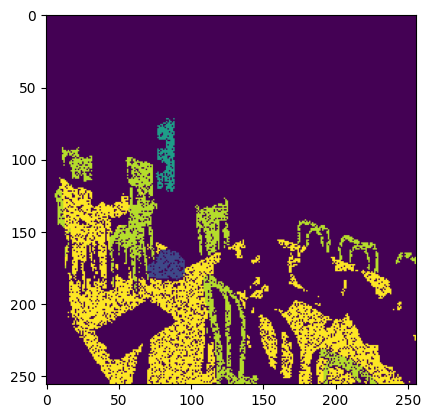

In [ ]:
plt.imshow(img_batch[3,:,:,3])

In [12]:
category_info_objetive = {1: 'person',
 3: 'car',
 4: 'motorcycle',
 6: 'bus',
 10: 'traffic light',
 27: 'backpack',
 31: 'handbag',
 77: 'cell phone',
 62: 'chair',
 67: 'dining table',
 0: 'background'}

In [13]:
yaml = {
    "dirs": {
        "anotaciones": {
            "train": "./dataset/coco/annotations/instances_train2017.json",
            "test": "./dataset/coco/annotations/instances_test2017.json",
            "val": "./dataset/coco/annotations/instances_val2017.json"
        },
        "imagenes": {
            "train": "./dataset/coco/train2017/",
            "test": "./dataset/coco/test2017/",
            "val": "./dataset/coco/val2017/"
        },
        "models": {
            "fastSAM": "./models/FastSAM-x.pt"
        }
    },
    "objetive_classes": [
        "person",
        "car",
        "motorcycle",
        "bus",
        "traffic light",
        "backpack",
        "handbag",
        "cell phone",
        "chair",
        "dining table"
    ],
    "size_sample": 30
}

In [14]:
objetives = yaml["objetive_classes"]
N_CLASSES = len(objetives) + 1

In [15]:
class IoULoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, ignore_index=0, eps=1e-6, name="iou_loss"):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.eps = eps

    def call(self, y_true, y_pred):
        # y_pred debe estar ya con softmax aplicado (o ser la salida del modelo con activation='softmax')
        probs = tf.clip_by_value(y_pred, self.eps, 1. - self.eps)

        ious = []
        for c in range(self.num_classes):
            if c == self.ignore_index:
                continue
            pred = probs[..., c]
            true = y_true[..., c]

            intersection = tf.reduce_sum(pred * true, axis=[1, 2])
            union = tf.reduce_sum(pred + true, axis=[1, 2]) - intersection

            iou = (intersection + self.eps) / (union + self.eps)
            ious.append(iou)

        iou = tf.reduce_mean(tf.stack(ious, axis=0), axis=0)
        return 1. - tf.reduce_mean(iou)


In [16]:
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.ce = tf.keras.losses.CategoricalCrossentropy()
        self.iou = IoULoss(num_classes=11, ignore_index=-1)

    def call(self, y_true, y_pred):
        return self.alpha * self.ce(y_true, y_pred) + (1 - self.alpha) * self.iou(y_true, y_pred)

In [17]:

def unet_light(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    return models.Model(inputs=inputs, outputs=outputs)


In [18]:
input_shape = (256, 256, 4)

model = unet_light(input_shape=input_shape, num_classes=N_CLASSES)


In [19]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 467,147 (1.78 MB)

 Trainable params: 467,147 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    # Caida del LR en intervalos discretos
    staircase=True       )

optimizer = Adam(learning_rate=initial_learning_rate)

In [21]:
# Priemra prueba para el entrenamiento más rapido posible
#model.compile(optimizer='adam', loss=BCEIoULoss(num_classes=len(category_info_objetive), ignore_index=0), metrics=['accuracy'])
model.compile(optimizer=optimizer,
              loss=CombinedLoss(alpha=0.6),
              #loss= 'categorical_crossentropy',#IoULoss(num_classes=len(category_info_objetive), ignore_index=0),
              metrics=['accuracy'])


# Callbacks para ir almacenando resultados, modificar el LR de forma dinámica parad hacer que el entrenamiento converja y frenar el entrenamiento del modelo cuando no se produzca aprendizaje
callbacks = [
    ModelCheckpoint(r"/content/drive/MyDrive/TFM/final_unet_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    CSVLogger(r"/content/drive/MyDrive/TFM/final_unet_model_training_log.csv")
]

In [22]:
train_dataset = carga_dataset(tfrecord_path_train, batch_size=16)
test_dataset = carga_dataset(tfrecord_path_test, batch_size=16)

In [23]:
history = model.fit(
    train_dataset.repeat(),
    steps_per_epoch=1000,
    validation_data=test_dataset.repeat(),
    validation_steps=400,
    epochs=50,
    callbacks= callbacks,
    verbose=1
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 319s 292ms/step - accuracy: 0.7102 - loss: 0.9840 - val_accuracy: 0.7781 - val_loss: 0.8288 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 277s 277ms/step - accuracy: 0.7856 - loss: 0.8063 - val_accuracy: 0.7911 - val_loss: 0.7772 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 327s 327ms/step - accuracy: 0.7960 - loss: 0.7775 - val_accuracy: 0.8011 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 274s 274ms/step - accuracy: 0.8045 - loss: 0.7545 - val_accuracy: 0.7994 - val_loss: 0.7570 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 281s 281ms/step - accuracy: 0.7994 - loss: 0.7641 - val_accuracy: 0.8103 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 323s 323ms/step - accuracy: 0.8096 - loss: 0.7370 - val_accuracy: 0.8090 - val_loss: 0.7534 - learning_rate: 0.0010
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 314s 314ms

In [36]:
train_dataset = carga_dataset(tfrecord_path_train, batch_size=16)
test_dataset = carga_dataset(tfrecord_path_test, batch_size=16)

def load_and_split_dataset(tfrecord_path, batch_size=16, val_batches=400, shuffle_buffer=10000):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    def parse(example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.decode_raw(parsed['image'], tf.uint8)
        image = tf.reshape(image, [256, 256, 4])
        image = tf.cast(image, tf.float32) / 255.0
        label = tf.cast(parsed['label'], tf.int32)
        return image, label

    dataset = raw_dataset.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=False)

    val_size = val_batches * batch_size
    val_dataset = dataset.take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    train_dataset = dataset.skip(val_size).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

train_dataset, val_dataset = load_and_split_dataset(tfrecord_path_train, batch_size=16)

test_dataset = carga_dataset(tfrecord_path_test, batch_size=16)


In [37]:
input_shape = (256, 256, 4)

model_final_pipeline = unet_light(input_shape=input_shape, num_classes=N_CLASSES)

In [38]:
model_final_pipeline.compile(optimizer=optimizer,
              loss=CombinedLoss(alpha=0.6),
              #loss= 'categorical_crossentropy',#IoULoss(num_classes=len(category_info_objetive), ignore_index=0),
              metrics=['accuracy'])


# Callbacks para ir almacenando resultados, modificar el LR de forma dinámica parad hacer que el entrenamiento converja y frenar el entrenamiento del modelo cuando no se produzca aprendizaje
callbacks = [
    ModelCheckpoint(r"/content/drive/MyDrive/TFM/final_unet_pipeline_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    CSVLogger(r"/content/drive/MyDrive/TFM/final_unet_training_log.csv")
]

In [39]:
history_2 = model_final_pipeline.fit(
    train_dataset,
    steps_per_epoch=1000,
    validation_data=val_dataset,
    validation_steps=400,
)

NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy en Train')
plt.plot(history.history['val_accuracy'], label='Accuracy en Validación')
plt.title('Accuracy del modelo final')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(loc='lower right')

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss en Train')
plt.plot(history.history['val_loss'], label='Loss en Validación')
plt.title('Loss del modelo final')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Obtención de métricas de rendimiento



/tmp/ipython-input-11-4257581388.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


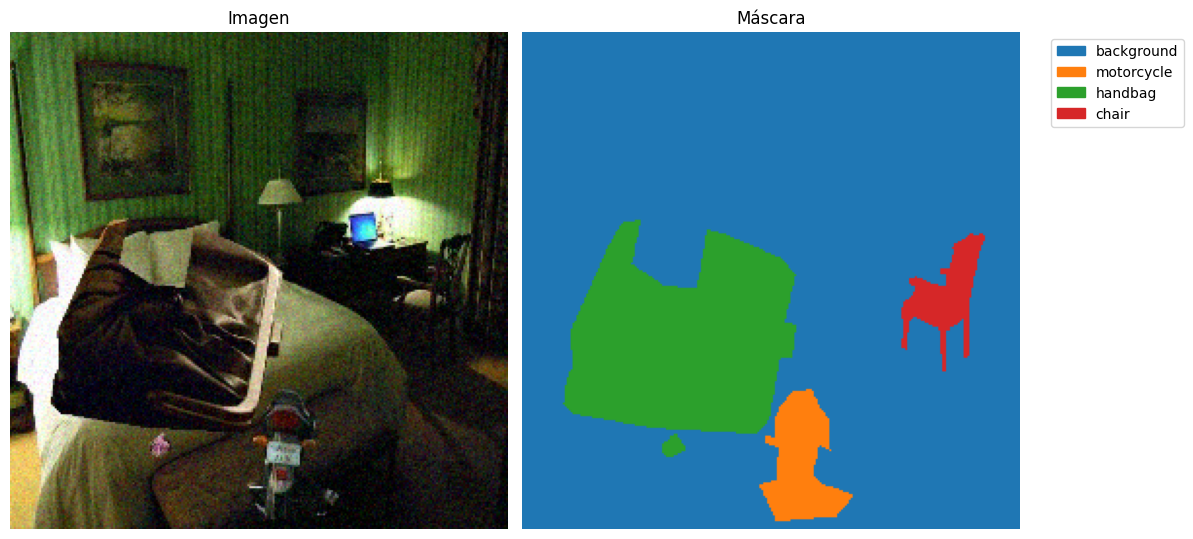

In [51]:
plot_image_and_mask(img_batch[3,:,:,:3], mask_batch[3,...])

In [52]:

model = keras.models.load_model(r"/content/drive/MyDrive/TFM/final_model.keras")#, custom_objects={'IoULoss': IoULoss})

In [53]:
predictions = model.predict(img_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


In [54]:
for x_batch, y_batch in train_ds.take(1):
    predictions = model.predict(x_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [55]:
predictions.shape

(4, 256, 256, 11)

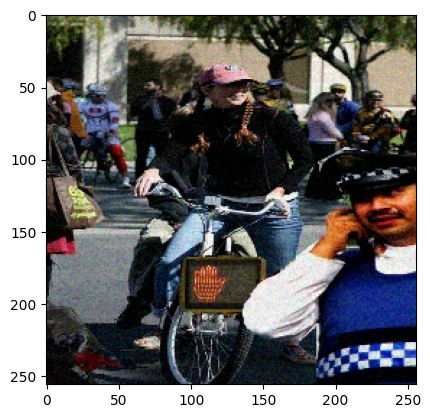

In [56]:
plt.imshow(x_batch[1,:,:,:3])

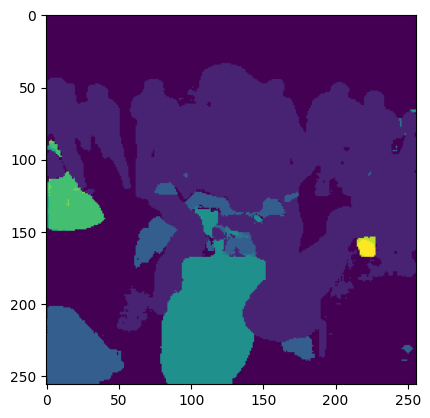

In [57]:
final_prediction = np.argmax(predictions[1,...], axis=-1)

plt.imshow(final_prediction)

In [116]:
def plot_image_and_mask_and_gt(image,previus_prediction, mask, gt):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}

    mask = np.argmax(mask, axis=2)
    class_ids = sorted([cid for cid in np.unique(list(np.unique(mask))+ list(np.unique(gt)))])

    # Uso de templates de colores predefinidas en matplot para que exista mas contraste entre clases de ids adyacentes, usando tab10
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    fig, ax = plt.subplots(1, 4, figsize=(14, 12))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    # Se incializa la mascara como todo fondo, y se itera añadiendo
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")



    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    #ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    mask_gt_colored = np.zeros((gt.shape[0],gt.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[gt==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[2].imshow(mask_gt_colored)
    ax[2].set_title("Predicción Modelo Final")
    ax[2].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    #ax[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')



    mask_gt_colored = np.zeros((previus_prediction.shape[0],previus_prediction.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[previus_prediction==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[3].imshow(mask_gt_colored)
    ax[3].set_title("Predicción Bloque anterior")
    ax[3].axis("off")

    # generación de la leyenda
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[3].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')




    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/tmp/ipython-input-116-1937715759.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


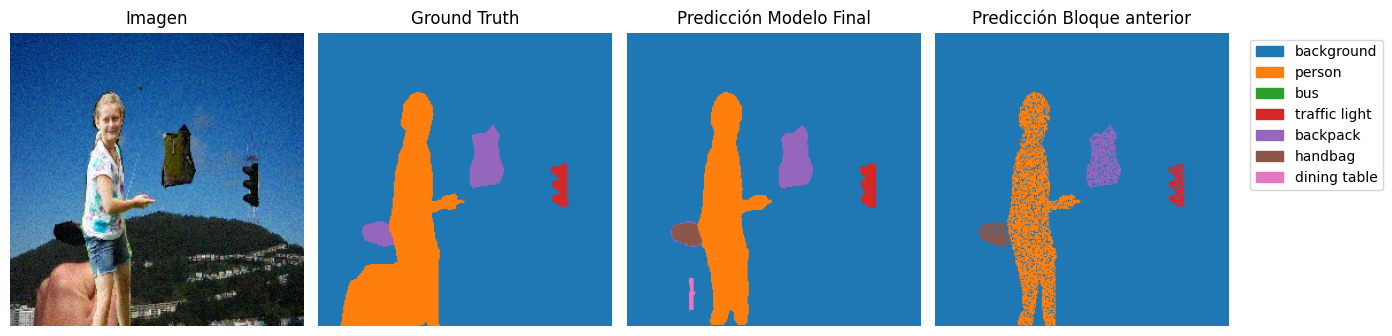

In [135]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[1,...], axis=-1)
    image = x_batch[1,:,:,:3]
    previus_prediction = x_batch[1,:,:,3]
    plot_image_and_mask_and_gt(image = image, previus_prediction = previus_prediction , mask = y_batch[1,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/tmp/ipython-input-116-1937715759.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


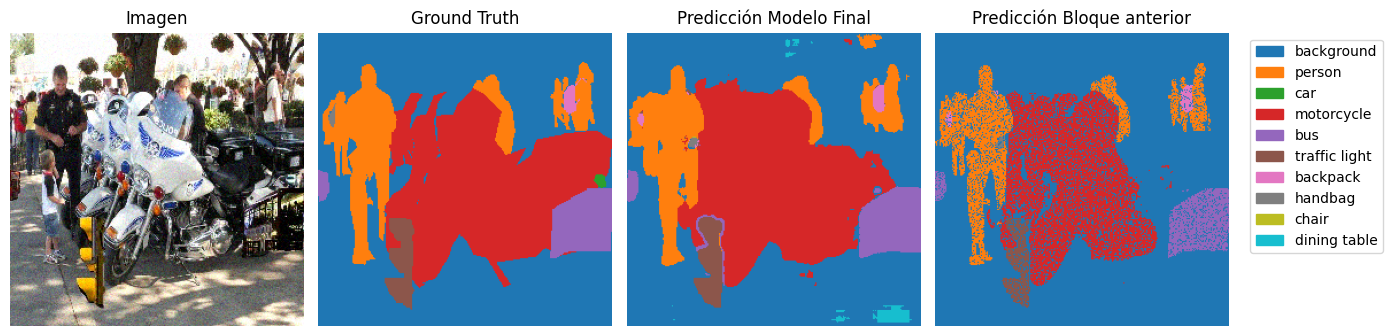

In [159]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[1,...], axis=-1)
    image = x_batch[1,:,:,:3]
    previus_prediction = x_batch[1,:,:,3]
    plot_image_and_mask_and_gt(image = image, previus_prediction = previus_prediction , mask = y_batch[1,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


/tmp/ipython-input-60-3793070104.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


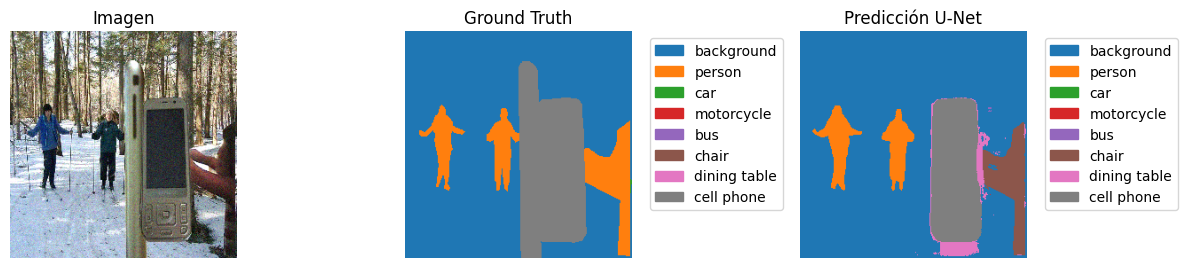

In [66]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,:,:,0:3] , mask = y_batch[0,...],gt =  final_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/tmp/ipython-input-60-3793070104.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


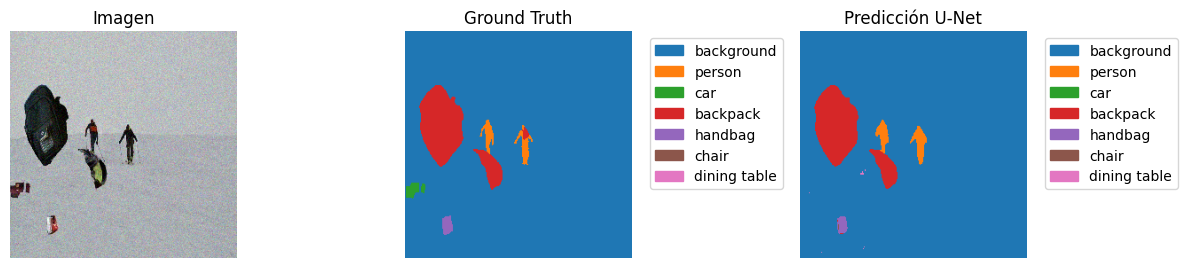

In [65]:
for x_batch, y_batch in test_dataset.take(1):
    predictions = model.predict(x_batch)
    final_prediction = np.argmax(predictions[0,...], axis=-1)
    plot_image_and_mask_and_gt(image = x_batch[0,:,:,0:3] , mask = y_batch[0,...],gt =  final_prediction)

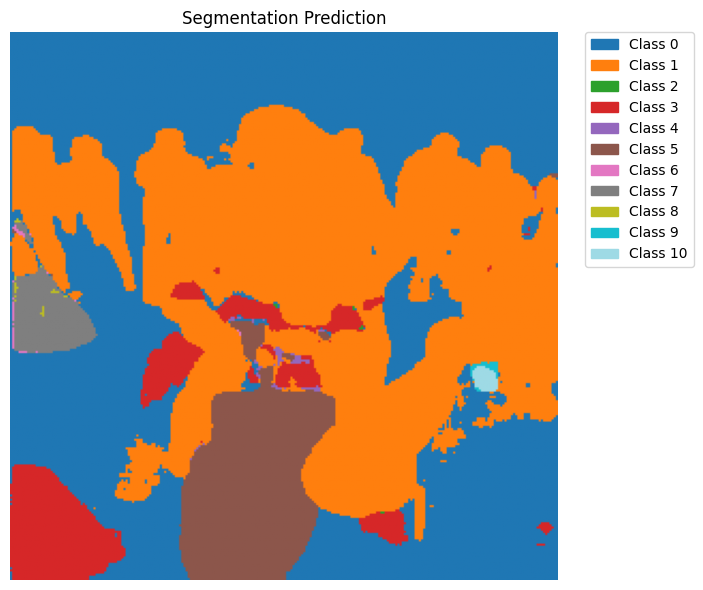

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Assume pred is your model output of shape (H, W, C)
prediction_result = np.argmax(predictions[1,...], axis=-1)  # shape: (H, W)

# Optional: define number of classes
num_classes = predictions[1,...].shape[-1]

# Define a colormap (can be custom or from matplotlib)
cmap = plt.get_cmap('tab20', num_classes)  # tab20 or any other discrete colormap

# Plot the prediction
plt.figure(figsize=(8, 6))
im = plt.imshow(prediction_result, cmap=cmap)
plt.title('Segmentation Prediction')
plt.axis('off')

# Create legend manually
patches = [mpatches.Patch(color=cmap(i), label=f'Class {i}') for i in range(num_classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
def get_one_hot_mask(current_scores, mask, num_classes):

    #print("we have shaoes ",current_scores.shape, mask.shape )

    one_hot_scores = np.zeros((num_classes, mask.shape[0], mask.shape[1]))

    for clase in range(num_classes):
        #print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)´
        one_hot_scores[clase ,:, :] = np.where(mask == clase, 1 , 0)

    #print(f"{one_hot_scores.shape}")
    one_hot_scores[0 ,:, :] = 1 - one_hot_scores[ 1:, :, :].sum(axis=0)


    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

In [ ]:

def compute_iou(pred_mask, true_mask) -> float:

    ious = []
    num_classes = pred_mask.shape[0]

    for c in range(num_classes):
        pred = pred_mask[c]
        truth = true_mask[c]

        if  truth.any():

            intersection = np.logical_and(pred, truth).sum()
            union = np.logical_or(pred, truth).sum()

            iou = intersection / union if union != 0 else 0.0
            ious.append(iou)


    return np.mean(ious)

In [ ]:
def mean_pixel_accuracy(pred_mask, true_mask) -> float:

    # print("Type of pred_mask:", type(pred_mask))
    # print("Shape of pred_mask:", pred_mask.shape)
    # print("Type of true_mask:", type(true_mask))
    # print("Shape of true_mask:", true_mask.shape)

    class_accuracies = []

    for c in range(pred_mask.shape[0]):
        pred = pred_mask[c]
        truth = true_mask[c]

        total_true = truth.sum()
        if total_true != 0:

            correct = np.logical_and(pred, truth).sum()
            acc = correct / total_true
            class_accuracies.append(acc)

            # print("For class ", c, " has value ", acc)

    return np.mean(class_accuracies)

In [ ]:
def mean_average_precision(prob_mask, true_mask) -> float:


    # print("weve shapes os ",prob_mask.shape, true_mask.shape )

    C, H, W = true_mask.shape
    aps = []

    for c in range(C):
        y_true = true_mask[c].ravel().astype(int)
        y_score = prob_mask[c].ravel()

        if y_true.sum() != 0:
            ap = average_precision_score(y_true, y_score)
            aps.append(ap)

            # print("for ", c, " has value ",ap)


    return np.mean(aps)

In [ ]:
def get_value_metrics(prob_mask, ground_truth) -> tuple[float, float, float ]:

    # plt.imshow(np.transpose(prob_mask[0:3,:,:], (1, 2, 0)))
    # plt.show()
    # plt.imshow(np.transpose(ground_truth[0:3,:,:], (1, 2, 0)))
    # plt.show()

    # result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)
    mean_pixel_acc = mean_pixel_accuracy(prob_mask, ground_truth)

    # result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)
    iou = compute_iou(prob_mask, ground_truth)

    # mean_average_precision(one_hot_scores[0],mask_one_hot_gt )
    mean_av_pre = mean_average_precision(prob_mask, ground_truth)

    return mean_pixel_acc, iou, mean_av_pre


In [ ]:
n_samples_batches = 200

list_mean_pixel_acc = []
list_iou = []
list_mean_av_prec = []
list_inference_time = []

ids_under_threshold = []
ids_over_threshold = []

for i, (img_batch, mask_batch) in enumerate(test_dataset.take(n_samples_batches)):

  if(i%5 == 0):
    clear_output(wait=True)

  #print("getting inference over batch ", i)
  #print(f"{img_batch.shape=}")
  comienzo_inferencia = time.time()
  predictions = model.predict(img_batch)
  fin_inferencia = time.time()


  for target_index in range(img_batch.shape[0]):
    try:
      #print(f"{mask_batch[target_index,...].shape=}")

      image, mask_gt = img_batch[target_index,...], mask_batch[target_index,...]
      #mask_gt = np.argmax(mask_gt, axis=-1)
      mask_gt = np.transpose(mask_gt, (2, 0, 1))

      mask_prediction = predictions[target_index,...]
      prediction_image = np.argmax(mask_prediction, axis=-1)


      final_predictions = get_one_hot_mask(mask_prediction, prediction_image, num_classes=num_classes )

      mean_pixel_acc, iou, mean_av_pre = get_value_metrics(final_predictions, mask_gt)
      #print("metrics are ", mean_pixel_acc, iou, mean_av_pre)


      list_mean_pixel_acc.append(mean_pixel_acc)
      list_iou.append(iou)
      list_mean_av_prec.append(mean_av_pre)
      list_inference_time.append(round((fin_inferencia -comienzo_inferencia)/img_batch.shape[0], 2) )

      if(mean_pixel_acc> 0.95):
        ids_over_threshold.append((i, target_index))

      elif(iou<0.5):
        ids_under_threshold.append((i, target_index))

    except Exception as e:
      print("Exception ", e , " at it ", i)



1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/

In [ ]:

CONS_OUTPUT_PATH = r"/content/drive/MyDrive/TFM/results.csv"

try:
    df = pd.read_csv(CONS_OUTPUT_PATH)
except Exception as e:
    df = pd.DataFrame()


results = pd.DataFrame({
    "Model":["Ensemble_Final"],
    "Mean_Pixel_Accuracy":[sum(list_mean_pixel_acc)/ len(list_mean_pixel_acc)],
    "Intersection_Over_Union":[sum(list_iou)/len(list_iou)],
    "Mean_Average_Precission":[sum(list_mean_av_prec)/len(list_mean_av_prec)],
    "Inference_Time":[sum(list_inference_time)/len(list_inference_time)]
})

df = pd.concat([df, results], ignore_index=True)




In [ ]:
df.head()

,Model,Mean_Pixel_Accuracy,Intersection_Over_Union,Mean_Average_Precission,Inference_Time
0,Ensable_RetinaNet+SAM,0.763368,0.648561,0.725264,31.00135
1,Ensable_YOLO+SAM,0.703540,0.596278,0.672659,95.58500
2,Ensemble_Final,0.553346,0.462333,0.495856,0.63790


In [ ]:
df.to_csv(CONS_OUTPUT_PATH, index=False)